In [147]:
## Standard :

# Name imports :
import os
import gc
import copy
import sklearn
import itertools
import time
import typing

# Aliased imports :
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

# Full imports :
from plotnine import *

In [148]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [149]:
def split(arr: list, count: int) -> typing.List[list]:
    return [arr[i::count] for i in range(count)]


def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Cast into a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def merge_date_time(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a dataframe containing columns:
        'Date'
        'Time'
        
        And return one containing a single column:
         'dateTime' = 'Date' + 'Time'
        
        For each entry as seen below:
         '2019-03-21 17:34:05' <- '2019-03-21' + '17:34:05'
    """
    _tmp = copy.deepcopy(df1)
    _tmp['dateTime'] = _tmp['Date'] + ' ' + _tmp['Time']
    _tmp.drop(['Date', 'Time'], axis=1, inplace=True)
    gc.collect()
    return _tmp
    

In [150]:
raw = pd.read_csv('data/carelink2.csv')

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,32,34,37,39,41,42,44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [151]:
raw.columns, len(raw.index)

(Index(['Index', 'Date', 'Time', 'New Device Time', 'BG Reading (mg/dL)',
        'Linked BG Meter ID', 'Basal Rate (U/h)', 'Temp Basal Amount',
        'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
        'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
        'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
        'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
        'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
        'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
        'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
        'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
        'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
        'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
        'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
        'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
        'Sensor C

In [152]:
#raw['Bolus Source'].value_counts()
#raw['Bolus Number'].value_counts()
#len(raw['dateTime'])
#raw['BWZ Unabsorbed Insulin Total (U)'].value_counts()
#raw['Bolus Cancellation Reason'].value_counts()
raw['Bolus Number'] = raw['Bolus Number'].apply(lambda x: int(x) if type(x) is str else x)

In [153]:
# Check if the list contains other thing than integers.
list(
    filter(
        lambda x: False if type(x) is int else True, raw['Final Bolus Estimate'].value_counts()
    )
)

[]

In [154]:
type(5) is int

True

In [155]:
raw = merge_date_time(raw)

In [156]:
# Remove ['MiniMed 640G MMT-1512/1712 Sensor', 'Date Time'] from the column, 
# as they impede coercing the values into timestamps.
for row in filter(lambda x: False if ':' in x else True, raw['dateTime'] ):
    raw = raw[raw.dateTime != row]

In [157]:
pool = mp.Pool(processes=4)
start = time.clock()
raw.dateTime = pool.map(pd.to_datetime, raw.dateTime)
elapsed = time.clock()
print(f'{elapsed - start}')

0.6754590000000036


In [143]:
start = time.clock()
raw.dateTime = list(map(pd.to_datetime, raw.dateTime))
elapsed = time.clock()
print(f'{elapsed - start}')

16.53772699999999


In [73]:
time

<module 'time' (built-in)>

In [20]:
start = time.clock()
raw.dateTime = raw.dateTime.apply(pd.to_datetime)
elapsed = time.clock()
print(f'{elapsed - start}')

16.885013999999998


In [121]:
type(raw.dateTime)

pandas.core.series.Series

In [133]:
undesired_columns = [
    'Index',
    'New Device Time',
    'Prime Type', 
    'Prime Volume Delivered (U)',
    'Alarm', 
    'Suspend', 
    'Rewind',
    'Linked BG Meter ID',
    'Bolus Cancellation Reason',
    'Scroll Step Size',
    'Sensor Calibration Rejected Reason',
    'Network Device Associated Reason',
    'Network Device Disassociated Reason',
    'Network Device Disconnected Reason',
    'Sensor Exception',
    'Preset Temp Basal Name',
    'Preset Bolus', 
    'Bolus Source'
]

In [134]:
raw = raw.drop(undesired_columns, axis=1)

KeyError: "['Index' 'Prime Type' 'Prime Volume Delivered (U)' 'Alarm' 'Suspend'\n 'Rewind' 'Linked BG Meter ID' 'Bolus Cancellation Reason'\n 'Scroll Step Size' 'Sensor Calibration Rejected Reason'\n 'Network Device Associated Reason' 'Network Device Disassociated Reason'\n 'Network Device Disconnected Reason' 'Sensor Exception'\n 'Preset Temp Basal Name' 'Preset Bolus' 'Bolus Source'] not found in axis"

In [128]:
raw['New Device Time'].value_counts()

2019/04/20 19:45:26    2
2019/04/16 09:15:48    2
2019/03/23 11:03:58    2
2019/04/01 12:06:12    2
2019/01/05 12:42:13    1
Name: New Device Time, dtype: int64

In [129]:
proc1 = time_indexed_df(raw)

In [132]:
proc1.loc['2019/04/01 12', :]

,New Device Time,BG Reading (mg/dL),Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Bolus Duration (h:mm:ss),...,BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Calibration BG (mg/dL),Sensor Glucose (mg/dL),ISIG Value,Event Marker,Bolus Number,BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate,Insulin Action Curve Time
dateTime,,,,,,,,,,,,,,,,,,,,,
2019-04-01 12:06:12,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:06:12,2019/04/01 12:06:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:07:00,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:09:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,98.0,17.89,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:10:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:10:12,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:14:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,92.0,17.36,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:19:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,86.0,16.78,NaN,NaN,NaN,NaN,NaN
2019-04-01 12:23:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
proc1.iloc[0, :], proc1.iloc[len(proc1.index)-1, :]

(New Device Time                                   NaN
 BG Reading (mg/dL)                                NaN
 Linked BG Meter ID                                NaN
 Basal Rate (U/h)                                  NaN
 Temp Basal Amount                                 NaN
 Temp Basal Type                                   NaN
 Temp Basal Duration (h:mm:ss)                     NaN
 Bolus Type                                        NaN
 Bolus Volume Selected (U)                         NaN
 Bolus Volume Delivered (U)                        NaN
 Bolus Duration (h:mm:ss)                          NaN
 Prime Type                                        NaN
 Prime Volume Delivered (U)                        NaN
 Alarm                                             NaN
 Suspend                                           NaN
 Rewind                                            NaN
 BWZ Estimate (U)                                  NaN
 BWZ Target High BG (mg/dL)                        NaN
 BWZ Targe

In [29]:
with open('dateTime.txt', 'w') as f:
    for i in raw['dateTime']:
        f.write(f'{i}\n')

In [30]:
raw.index, raw['Index']

(RangeIndex(start=0, stop=96130, step=1), 0            0.0
 1            1.0
 2            2.0
 3            3.0
 4            4.0
 5            5.0
 6            6.0
 7            7.0
 8            8.0
 9            9.0
 10          10.0
 11          11.0
 12          12.0
 13          13.0
 14          14.0
 15          15.0
 16          16.0
 17          17.0
 18          18.0
 19          19.0
 20          20.0
 21          21.0
 22          22.0
 23          23.0
 24          24.0
 25          25.0
 26          26.0
 27          27.0
 28          28.0
 29          29.0
           ...   
 96100    96100.0
 96101    96101.0
 96102    96102.0
 96103    96103.0
 96104    96104.0
 96105    96105.0
 96106    96106.0
 96107    96107.0
 96108    96108.0
 96109    96109.0
 96110    96110.0
 96111    96111.0
 96112    96112.0
 96113    96113.0
 96114    96114.0
 96115    96115.0
 96116    96116.0
 96117    96117.0
 96118    96118.0
 96119    96119.0
 96120    96120.0
 96121    96121.0
 9612

In [31]:
raw['New Device Time'].count()

9

In [32]:
raw[ raw['New Device Time'].notnull() ]['New Device Time']

273      2019/04/20 19:45:26
274      2019/04/20 19:45:26
837      2019/04/16 09:15:48
838      2019/04/16 09:15:48
2633     2019/04/01 12:06:12
2634     2019/04/01 12:06:12
3684     2019/03/23 11:03:58
3685     2019/03/23 11:03:58
12864    2019/01/05 12:42:13
Name: New Device Time, dtype: object

In [33]:
list(
    map(
        type, list(raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)'])
    )
)

[float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,


In [34]:
glucosas = raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)']

In [35]:
glucosas = pd.to_numeric(glucosas, 'coerce')

In [36]:
glucosas = glucosas[glucosas == glucosas // 1]

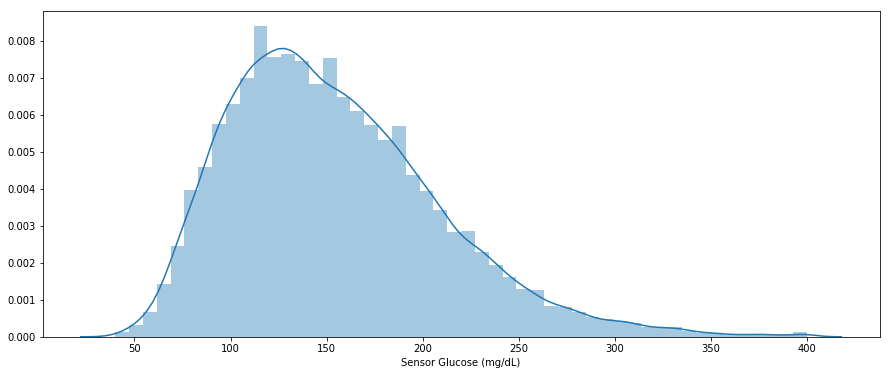

In [37]:
sb.distplot(glucosas)

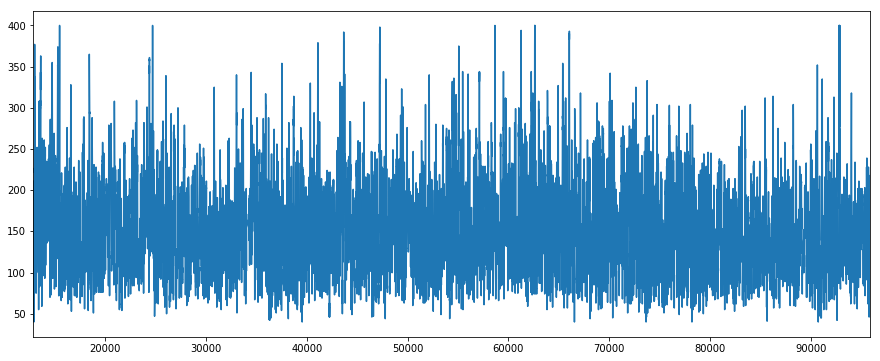

In [38]:
glucosas.plot()

In [46]:
proporciones = (lambda borne_inf, borne_sup: 
                { 
                    'hypo':  100 * glucosas[glucosas < borne_inf].count() / glucosas.count(),
                    'normo': 100 * glucosas[(glucosas >= borne_inf) & (glucosas <=borne_sup)].count() / glucosas.count(),
                    'hyper': 100 * glucosas[glucosas > borne_sup].count() / glucosas.count()
                }
)(70, 160)

In [48]:
proporciones

{'hypo': 2.0057487204054363,
 'normo': 57.465772421270266,
 'hyper': 40.5284788583243}

In [49]:
glucosas.mean(), glucosas.std()

(154.36552280577897, 55.004304897107545)

In [50]:
raw['BWZ Estimate (U)'].count()/90

7.611111111111111

In [51]:
raw.iloc[0,:], raw.iloc[len(raw.index)-1, :]

(Index                                                  0
 Date                                          2019/04/23
 Time                                            17:00:00
 New Device Time                                      NaN
 BG Reading (mg/dL)                                   NaN
 Linked BG Meter ID                                   NaN
 Basal Rate (U/h)                                    0.78
 Temp Basal Amount                                    NaN
 Temp Basal Type                                      NaN
 Temp Basal Duration (h:mm:ss)                        NaN
 Bolus Type                                           NaN
 Bolus Volume Selected (U)                            NaN
 Bolus Volume Delivered (U)                           NaN
 Bolus Duration (h:mm:ss)                             NaN
 Prime Type                                           NaN
 Prime Volume Delivered (U)                           NaN
 Alarm                                                NaN
 Suspend      

In [29]:
x = pd.core.frame.DataFrame()

In [96]:
'''
glucosas = filter(lambda x: x if not np.isnan(x) else False,
                  list(
                    map(int, glucosas)
                    )
            )
#Value error: cannot convert float NaN to integer
'''    

'\nglucosas = filter(lambda x: x if not np.isnan(x) else False,\n                  list(\n                    map(int, glucosas)\n                    )\n            )\n#Value error: cannot convert float NaN to integer\n'